In [98]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

sys.path.append('..')

from utils import gen_covariance, gen_beta2, gen_data, get_cov_list
from utils import selection_accuracy
from sklearn.linear_model import LassoLars, lasso_path, LinearRegression

from pyuoi.linear_model import UoI_Lasso

In [7]:
import itertools, scipy, risk

### Consider a paired down, 10 feature linear regression problem. There is an optimal "correct" model living in a particular 4 feature subspace of the full parameter space. There are 1024 distinct model supports. Some large subset of these model supports will also contain "correct" models. The problem with using a likelihood based risk function is that the resultant estimated distributions will exhibit nearly the same risk. Let's illustrate this explicitly:

In [58]:
n_features = 10
n_samples = 50

# Diagonal covariance
sigma = gen_covariance(n_features, 0, n_features, 1, 0)

# Beta 
beta = gen_beta2(n_features, n_features, 0.4)

# Data
X, X_test, y, y_test, ss = gen_data(n_samples, n_features, covariance = sigma, beta = beta, kappa = 3)

# # Center the generated data:
# y -= np.mean(y)
# # Normalize the predictors to have unit variance
# X -= np.mean(X, axis = 0)
# X /= np.std(X, axis = 0)

# Search through all possible models and narrow it down to correct models
supports = list(itertools.product([0, 1], repeat = 10))
correct = np.zeros(len(supports))
for i, s in enumerate(supports):
    if np.array_equal(np.bitwise_and(beta.ravel() != 0, s), beta.ravel() != 0):
        correct[i] = 1
        
# For all correct models, fit OLS models. 
correct_supports = np.array(supports)[correct.astype(bool)].astype(bool)
models = np.zeros(correct_supports.shape)
intercepts = np.zeros(correct_supports.shape[0])
for i in range(correct_supports.shape[0]):
    cs = correct_supports[i, :]
    if X[:, cs].size > 0:
        linmodel = LinearRegression().fit(X[:, cs], y)
        models[i, cs] = linmodel.coef_.ravel()
        intercepts[i] = linmodel.intercept_ 
        
# For all incorrect models, fit OLS models.
incorrect_supports = np.array(supports)[np.invert(correct.astype(bool))].astype(bool)
imodels = np.zeros(incorrect_supports.shape)
iintercepts = np.zeros(incorrect_supports.shape[0])
for i in range(incorrect_supports.shape[0]):
    ics = incorrect_supports[i, :]
    if X[:, ics].size > 0:
        linmodel = LinearRegression().fit(X[:, ics], y)
        imodels[i, ics] = linmodel.coef_.ravel()
        iintercepts[i] = linmodel.intercept_ 

# Assess the ordinary risk on all models
exact_risk = np.zeros(models.shape[0])
exact_risk_test = np.zeros(models.shape[0])

iexact_risk = np.zeros(imodels.shape[0])
iexact_risk_test = np.zeros(imodels.shape[0])

empirical_risk = np.zeros(models.shape[0])
empirical_risk_test = np.zeros(models.shape[0])

iempirical_risk = np.zeros(imodels.shape[0])
iempirical_risk_test = np.zeros(imodels.shape[0])

MIC_risk = np.zeros(models.shape[0])
iMIC_risk = np.zeros(imodels.shape[0])

for i in range(models.shape[0]):
    y_pred = X @ models[i, :] + intercepts[i]
    sigma_hat = np.mean((y - y_pred)**2)
    exact_risk[i] = risk.calc_KL_div(y_pred, sigma_hat, ss)
    empirical_risk[i] = risk.MIC(y, y_pred, 
                                 np.count_nonzero(models[i, :]), 0)
    MIC_risk[i] = risk.MIC(y, y_pred, np.count_nonzero(models[i, :]), 2)
    
    
for i in range(imodels.shape[0]):
    y_pred = X @ imodels[i, :] + iintercepts[i]
    sigma_hat = np.mean((y - y_pred)**2)
    iexact_risk[i] = risk.calc_KL_div(y_pred, sigma_hat, ss)
    iempirical_risk[i] = risk.MIC(y, y_pred,
                                  np.count_nonzero(imodels[i, :]), 0)
    iMIC_risk[i] = risk.MIC(y, y_pred, np.count_nonzero(imodels[i, :]), 2)    

# Distribution of the exact risk as a function of selection_accuracy
support_sa = selection_accuracy(beta.ravel(), models)
isupport_sa = selection_accuracy(beta.ravel(), imodels)

In [46]:
# Do the same thing, but with different sparsity:
n_features = 10
n_samples = 50

# Diagonal covariance
sigma = gen_covariance(n_features, 0, n_features, 1, 0)

# Beta 
beta = gen_beta2(n_features, n_features, 0.8)

# Data
X, X_test, y, y_test, ss = gen_data(n_samples, n_features, covariance = sigma, beta = beta, kappa = 3)

# # Center the generated data:
# y -= np.mean(y)
# # Normalize the predictors to have unit variance
# X -= np.mean(X, axis = 0)
# X /= np.std(X, axis = 0)

# Search through all possible models and narrow it down to correct models
supports = list(itertools.product([0, 1], repeat = 10))
correct = np.zeros(len(supports))
for i, s in enumerate(supports):
    if np.array_equal(np.bitwise_and(beta.ravel() != 0, s), beta.ravel() != 0):
        correct[i] = 1
        
# For all correct models, fit OLS models. 
correct_supports = np.array(supports)[correct.astype(bool)].astype(bool)
models = np.zeros(correct_supports.shape)
intercepts = np.zeros(correct_supports.shape[0])
for i in range(correct_supports.shape[0]):
    cs = correct_supports[i, :]
    if X[:, cs].size > 0:
        linmodel = LinearRegression().fit(X[:, cs], y)
        models[i, cs] = linmodel.coef_.ravel()
        intercepts[i] = linmodel.intercept_ 
        
# For all incorrect models, fit OLS models.
incorrect_supports = np.array(supports)[np.invert(correct.astype(bool))].astype(bool)
imodels = np.zeros(incorrect_supports.shape)
iintercepts = np.zeros(incorrect_supports.shape[0])
for i in range(incorrect_supports.shape[0]):
    ics = incorrect_supports[i, :]
    if X[:, ics].size > 0:
        linmodel = LinearRegression().fit(X[:, ics], y)
        imodels[i, ics] = linmodel.coef_.ravel()
        iintercepts[i] = linmodel.intercept_ 

# Assess the ordinary risk on all models
exact_risk2 = np.zeros(models.shape[0])
exact_risk2_test = np.zeros(models.shape[0])

iexact_risk2 = np.zeros(imodels.shape[0])
iexact_risk2_test = np.zeros(imodels.shape[0])

empirical_risk2 = np.zeros(models.shape[0])
empirical_risk2_test = np.zeros(models.shape[0])

iempirical_risk2 = np.zeros(imodels.shape[0])
iempirical_risk2_test = np.zeros(imodels.shape[0])

MIC_risk2 = np.zeros(models.shape[0])
iMIC_risk2 = np.zeros(imodels.shape[0])

for i in range(models.shape[0]):
    y_pred = X @ models[i, :] + intercepts[i]
    sigma_hat = np.mean((y - y_pred)**2)
    exact_risk2[i] = risk.calc_KL_div(y_pred, sigma_hat, ss)
    empirical_risk2[i] = risk.MIC(y, y_pred, 
                                 np.count_nonzero(models[i, :]), 0)
    MIC_risk2[i] = risk.MIC(y, y_pred, np.count_nonzero(models[i, :]), 2)
    
    
for i in range(imodels.shape[0]):
    y_pred = X @ imodels[i, :] + iintercepts[i]
    sigma_hat = np.mean((y - y_pred)**2)
    iexact_risk2[i] = risk.calc_KL_div(y_pred, sigma_hat, ss)
    iempirical_risk2[i] = risk.MIC(y, y_pred,
                                  np.count_nonzero(imodels[i, :]), 0)
    iMIC_risk2[i] = risk.MIC(y, y_pred, np.count_nonzero(imodels[i, :]), 2)    

# Distribution of the exact risk as a function of selection_accuracy
support_sa2 = selection_accuracy(beta.ravel(), models)
isupport_sa2 = selection_accuracy(beta.ravel(), imodels)

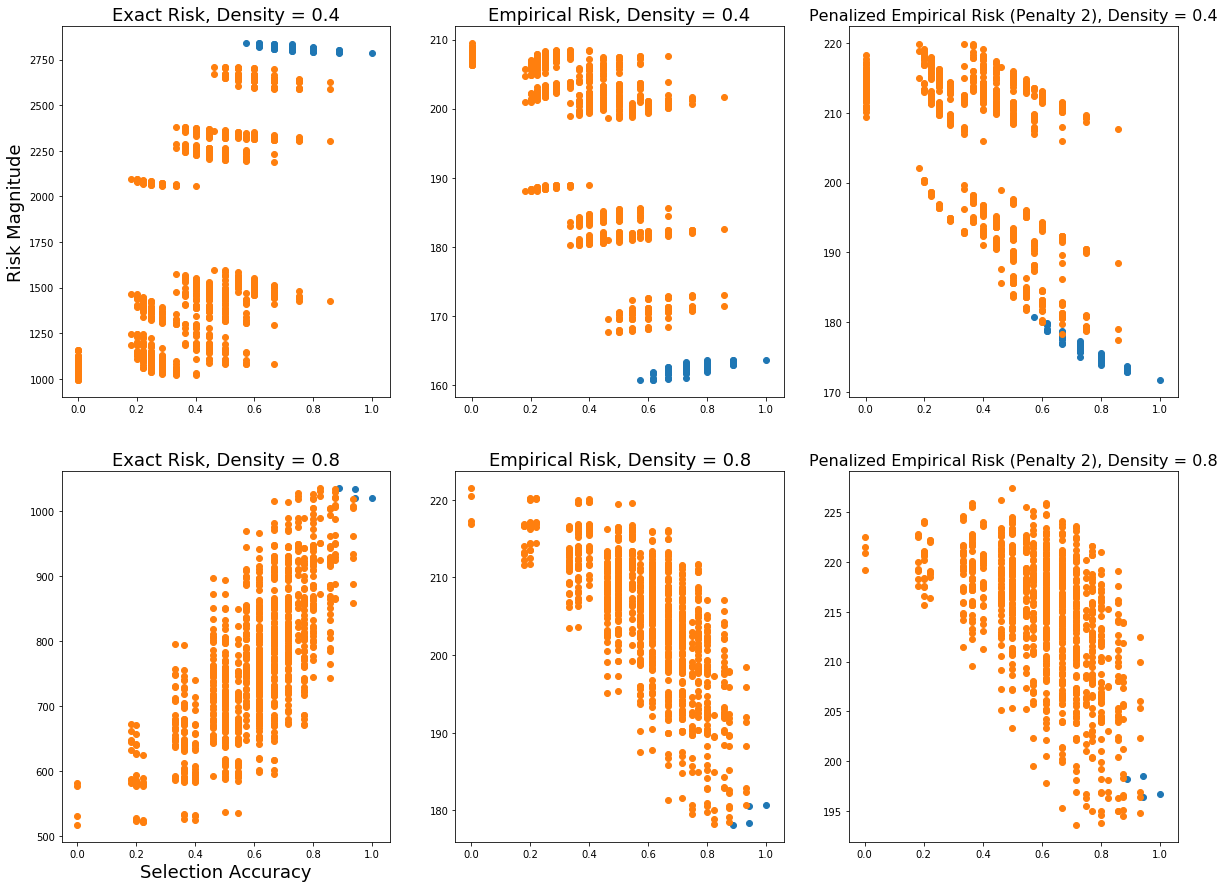

In [57]:
fig, ax = plt.subplots(2, 3, figsize = (20, 15))

ax[0, 0].scatter(support_sa, exact_risk)
ax[0, 0].scatter(isupport_sa, iexact_risk)
ax[0, 0].set_title('Exact Risk, Density = 0.4', fontsize = 18)
ax[0, 0].set_ylabel('Risk Magnitude', fontsize = 18)

ax[0, 1].scatter(support_sa, empirical_risk)
ax[0, 1].scatter(isupport_sa, iempirical_risk)
ax[0, 1].set_title('Empirical Risk, Density = 0.4', fontsize = 18)

ax[0, 2].scatter(support_sa, MIC_risk)
ax[0, 2].scatter(isupport_sa, iMIC_risk)
ax[0, 2].set_title('Penalized Empirical Risk (Penalty 2), Density = 0.4', fontsize = 16)

ax[1, 0].scatter(support_sa2, exact_risk2)
ax[1, 0].scatter(isupport_sa2, iexact_risk2)
ax[1, 0].set_title('Exact Risk, Density = 0.8', fontsize = 18)
ax[1, 0].set_xlabel('Selection Accuracy', fontsize = 18)

ax[1, 1].scatter(support_sa2, empirical_risk2)
ax[1, 1].scatter(isupport_sa2, iempirical_risk2)
ax[1, 1].set_title('Empirical Risk, Density = 0.8', fontsize = 18)


ax[1, 2].scatter(support_sa2, MIC_risk2)
ax[1, 2].scatter(isupport_sa2, iMIC_risk2)
ax[1, 2].set_title('Penalized Empirical Risk (Penalty 2), Density = 0.8', fontsize = 16)

plt.savefig('10featureRisk.pdf', bbox_inches = 'tight', pad_inches = 0)

### Instead of considering all possible subsets, use UoI to do feature selection

In [59]:
uoil = UoI_Lasso(fit_intercept = True, estimation_score = 'MIC', 
                 manual_penalty = np.linspace(0, 8, 80), true_support = beta.ravel())
uoil.fit(X, y)

> c:\users\akumar\nse\pyuoi\pyuoi\linear_model\base.py(442)fit()
-> pdb.set_trace()
(Pdb) continue


UoI_Lasso(comm=None, copy_X=None, eps=0.001, estimation_frac=0.9,
     estimation_score='MIC', fit_intercept=True,
     manual_penalty=array([0.     , 0.10127, ..., 7.89873, 8.     ]),
     max_iter=1000, n_boots_est=48, n_boots_sel=48, n_lambdas=48,
     random_state=<module 'numpy.random' from 'C:\\Users\\akumar\\Anaconda3\\envs\\nse\\lib\\site-packages\\numpy\\random\\__init__.py'>,
     selection_frac=0.9, stability_selection=1.0, standardize=True,
     true_support=array([0.     , 0.     , 0.     , 1.64986, 9.99813, 3.58925, 3.4685 ,
       0.     , 0.     , 0.     ]),
     warm_start=None)

In [60]:
selection_accuracy(beta.ravel(), uoil.coef_)

array([0.85714286])

In [61]:
from sklearn.linear_model import LassoCV

In [62]:
lasso = LassoCV(n_alphas = 48, cv = 5, normalize = True).fit(X, y.ravel())


In [63]:
selection_accuracy(beta.ravel(), lasso.coef_)

array([0.5])

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [66]:
# Reproduce the situation above, but now fit the models on 90 % of the data and evaluate test scores on the remaining 10 %.

# Create bootstraps
n_boots = 48

boot_exact_risk = np.zeros((uoil.supports_.shape[0], n_boots))
boot_exact_risk_test = np.zeros((uoil.supports_.shape[0], n_boots))

boot_empirical_risk = np.zeros((uoil.supports_.shape[0], n_boots))
boot_empirical_risk_test = np.zeros((uoil.supports_.shape[0], n_boots))

boot_MIC = np.zeros((uoil.supports_.shape[0], n_boots))
boot_MIC_test = np.zeros((uoil.supports_.shape[0], n_boots))

boot_sa = np.zeros((uoil.supports_.shape[0], n_boots))

boot_models = np.zeros(((uoil.supports_.shape) + (n_boots,)))

for i in range(uoil.supports_.shape[0]):

    s = uoil.supports_[i, :]
    
    for boot in range(n_boots):
        
        # Bootstrap the data:
        train_idxs, test_idxs = train_test_split(np.arange(X.shape[0]),
                                                test_size = 0.1)
        X_b = X[train_idxs]
        X_t = X[test_idxs]
        y_b = y[train_idxs]
        y_t = y[test_idxs]
                

        m = np.zeros(n_features)
        
        if X_b[:, s].size > 0:
            # Fit OLS model
            mm = LinearRegression().fit(X_b[:, s], y_b)
            m[s] = mm.coef_.ravel()
            y_pred = mm.predict(X_b[:, s]) - mm.intercept_
        else:
            y_pred = np.zeros(y_b.shape)
        
        # Calculate risks on bootstrap and test samples:
        sigma_hat = np.mean((y_b - y_pred)**2)
        boot_exact_risk[i, boot] = risk.calc_KL_div(y_pred, np.sqrt(sigma_hat), np.sqrt(ss))

        boot_empirical_risk[i, boot] = risk.empirical_KL_estimate(y_b, y_pred)
        boot_MIC[i, boot] = risk.MIC(y_b, y_pred, np.count_nonzero(m.ravel()), 1)

        sigma_hat = np.mean(np.linalg.norm(y_t - X_t @ m.ravel()))
        boot_exact_risk_test[i, boot] = risk.calc_KL_div(X_t @ m.ravel(), np.sqrt(sigma_hat), np.sqrt(ss))
        boot_empirical_risk_test[i, boot] = risk.empirical_KL_estimate(y_t, X_t @ m.ravel())
        boot_MIC_test[i, boot] = risk.MIC(y_t, X_t @ m.ravel(), np.count_nonzero(m.ravel()), 1)

        boot_sa[i, boot] = selection_accuracy(beta.ravel(), m)

In [67]:
uoil.estimates_.shape

(48, 8, 10)

In [68]:
uoil_sa = np.zeros((uoil.estimates_.shape[0], uoil.estimates_.shape[1]))
for i in range(uoil.estimates_.shape[0]):
    for j in range(uoil.estimates_.shape[1]):
        uoil_sa[i, j] = selection_accuracy(beta.ravel(), uoil.estimates_[i, j, :])TThe

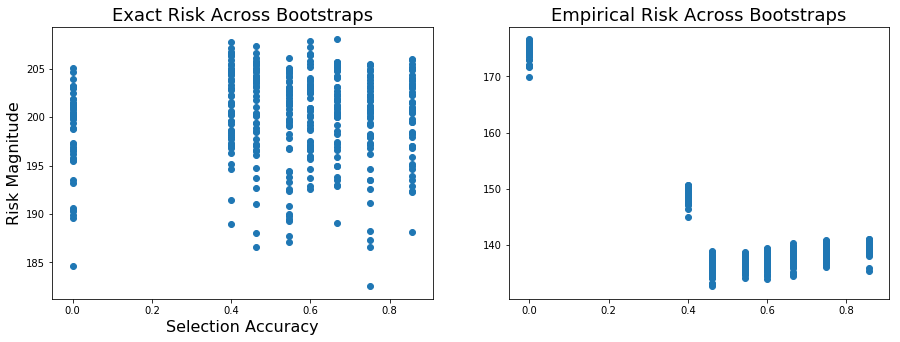

In [93]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].scatter(boot_sa.ravel(), boot_exact_risk.ravel())
ax[0].set_title('Exact Risk Across Bootstraps', fontsize = 18)
ax[0].set_xlabel('Selection Accuracy', fontsize = 16)
ax[0].set_ylabel('Risk Magnitude', fontsize = 16)
ax[1].scatter(boot_sa.ravel(), boot_empirical_risk.ravel())
ax[1].set_title('Empirical Risk Across Bootstraps', fontsize = 18)

fig.savefig('exact_risk_boot.pdf', bbox_inches = 'tight', pad_inches = 0)

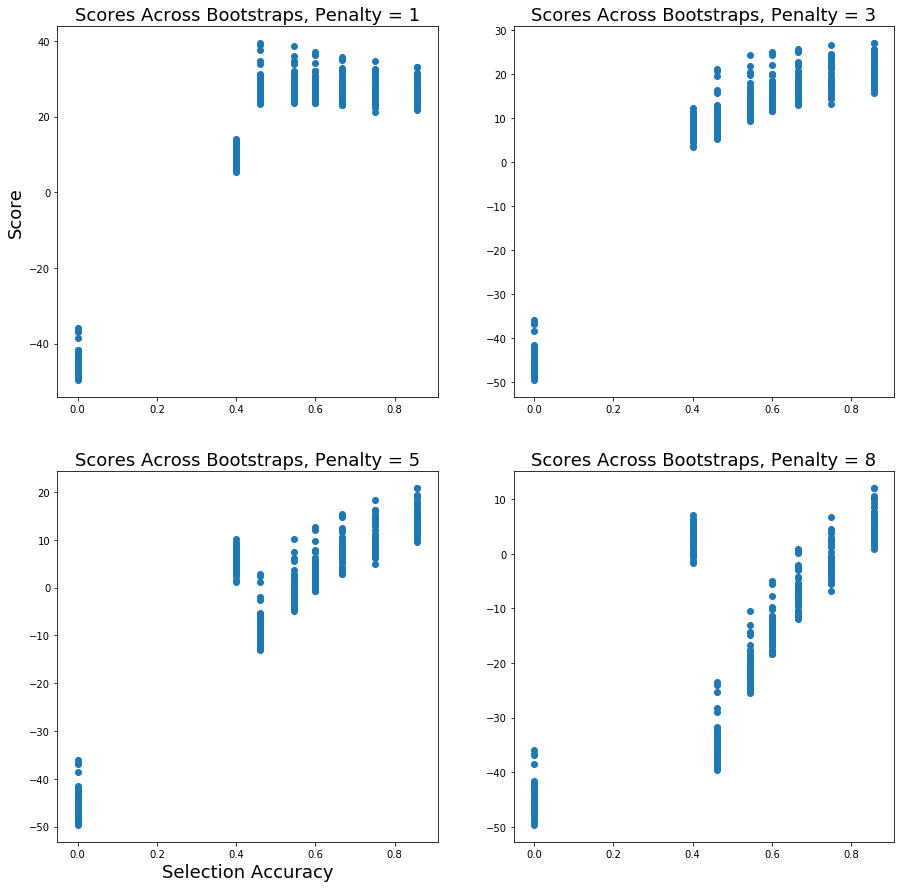

In [97]:
fig, ax = plt.subplots(2, 2, figsize = (15, 15))

ax[0, 0].scatter(uoil_sa.ravel(), uoil.scores_[..., 10].ravel())
ax[0, 0].set_ylabel('Score', fontsize = 18)
ax[0, 0].set_title('Scores Across Bootstraps, Penalty = 1', fontsize = 18)
ax[0, 1].scatter(uoil_sa.ravel(), uoil.scores_[..., 30].ravel())
ax[0, 1].set_title('Scores Across Bootstraps, Penalty = 3', fontsize = 18)
ax[1, 0].scatter(uoil_sa.ravel(), uoil.scores_[..., 50].ravel())
ax[1, 0].set_title('Scores Across Bootstraps, Penalty = 5', fontsize = 18)
ax[1, 0].set_xlabel('Selection Accuracy', fontsize = 18)
ax[1, 1].scatter(uoil_sa.ravel(), uoil.scores_[..., 79].ravel())
ax[1, 1].set_title('Scores Across Bootstraps, Penalty = 8', fontsize = 18)

fig.savefig('uoi_boot_risks.pdf')